## 估计模型参数

In [10]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm  # 贝叶斯相关包，需要安装
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm
%matplotlib inline

plt.style.use('bmh')
colors = ['#348ABD','#A60628','#7A68A6','#467821','#D55E00',
          '#CC79A7','#56B4E9','#009E73','#F0F442','#0072B2']

messages = pd.read_csv('hangout_chat_data.csv')  # 某人的聊天数据，如回复信息的速度等

**贝叶斯看待数据的思维**

假设蹲在山上数羊 12，33，20，29，20，30，18（每天数看到几只羊，得到一周的数据）

按照贝叶斯的思想，数据已经定下来了，减下来就是找到参数的概率分布

我们的数据是非负的整数，在这里我们用泊松分布来建模，泊松分布只需要μ，它描述数据的均值和方差
<img src="assets/20201128183746.png" width="30%">

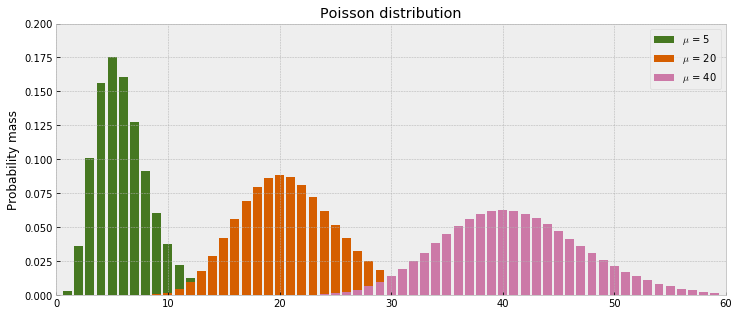

In [14]:
# 画出泊松分布的图
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
x_lim = 60
mu = [5,20,40]
for i in np.arange(x_lim):
    plt.bar(i,stats.poisson.pmf(mu[0],i),color=colors[3])
    plt.bar(i,stats.poisson.pmf(mu[1],i),color=colors[4])
    plt.bar(i,stats.poisson.pmf(mu[2],i),color=colors[5])
    
_ = ax.set_xlim(0,x_lim)
_ = ax.set_ylim(0,0.2)
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Poisson distribution')
_ = plt.legend(['$\mu$ = %s' % mu[0], '$\mu$ = %s' % mu[1], '$\mu$ = %s' % mu[2]])

不同的mu值下的泊松分布长相

回消息的反应时间的分布情况

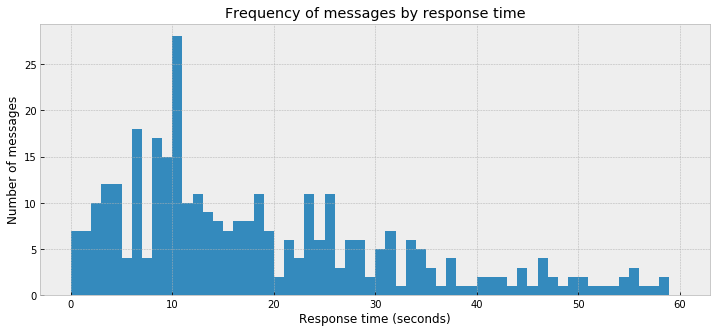

In [15]:
fig = plt.figure(figsize=(12,5))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
_ = plt.hist(messages['time_delay_seconds'].values,
             range=[0, 60], bins=60, histtype='stepfilled')

y轴是回复的样本个数，x轴是消息发来的回复时间。

10秒的时候回复最多

**极大似然估计求μ**

在用贝叶斯方法之前，先用最大似然估计来求解。
<ul>
    <li>poisson_logprob()根据泊松模型和参数值返回观测数据的总似然值。
    <li>opt.minimize_scalar找到最合适的取值。

In [17]:
y_obs = messages['time_delay_seconds'].values

def poisson_logprob(mu, sign=-1):
    return np.sum(sign*stats.poisson.logpmf(y_obs, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)
%time print("The estimated value of mu is: %s" % freq_results['x'])

The estimated value of mu is: 18.2307692323807
Wall time: 0 ns


得到结果μ = 18.2307692323807，但这仅仅是一个值。

下面展示这个过程，不断爬坡的过程。

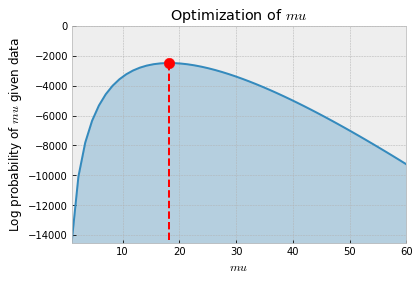

In [18]:
x = np.linspace(1, 60)
y_min = np.min([poisson_logprob(i, sign=1) for i in x])
y_max = np.max([poisson_logprob(i, sign=1) for i in x])

fig = plt.figure(figsize=(6,4))
_ = plt.plot(x, [poisson_logprob(i, sign=1) for i in x])
_ = plt.fill_between(x, [poisson_logprob(i, sign=1) for i in x], 
                     y_min, color=colors[0], alpha=0.3)

_ = plt.title('Optimization of $mu$')
_ = plt.xlabel('$mu$')
_ = plt.ylabel('Log probability of $mu$ given data')
_ = plt.vlines(freq_results['x'], y_max, y_min, colors='red', linestyles='dashed')
_ = plt.scatter(freq_results['x'], y_max, s=110, c='red', zorder=3)
_ = plt.ylim(ymin=y_min, ymax=0)
_ = plt.xlim(xmin=1, xmax=60)

代入参数后分布的样子

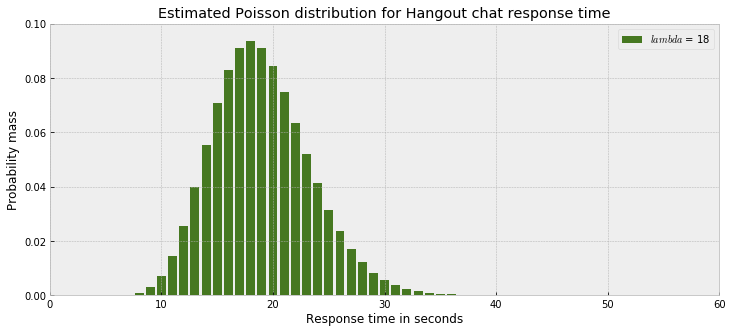

In [19]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
x_lim = 60
mu = np.int(freq_results['x'])

for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])

_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.1)
_ = ax.set_xlabel('Response time in seconds')
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Estimated Poisson distribution for Hangout chat response time')
_ = plt.legend(['$lambda$ = %s' % mu])

上述泊松分布模型和 μ 的估计表明，观测小于10 或大于 30 的可能性很小，绝大多数的概率分布在 10 和 30 之间。但是，这不能反映我们观测到的介于 0 到 60 之间的数据。

#### 贝叶斯方法估计μ

<img src="assets/20201128203033.png" width="30%">

<img src="assets/20201128203246.png" width="30%">

上述可解读如下（从下到上）：
<ul>
    <li>对每一个对话（i）观测计数数据（y）
    <li>数据由一个随机过程产生，我们认为可以用泊松分布模拟
    <li>泊松分布只有一个参数，介于 0 到 60 之间
    <li>均匀分布的原因在于并没有提及任何条件

**马尔可夫链蒙特卡洛方法MCMC**

贝叶斯公式的只是一个参数，但如果我们的问题涉及到多个参数呢？分布的积分就应该改成多重积分，但是难点在于我们该怎么算，MCMC采样器从先验分布中选取参数值，计算从这些参数值决定的某个分布中得到观测数据的可能性。这个计算可以作为MCMC采样器的导引。从参数的先验分布中选取值，然后计算给定数据条件下这些参数值可能性——导引采样器到更高概率的区域。与上面讨论的频率论优化技术在概念上有相似之处，MCMC采样器向可能性最高的区域运动。但是，贝叶斯方法不关心寻找绝对最大值，而是遍历和收集概率最高区域附近的样本。所有收集到的样本都可认为是一个可信的参数

**蒙特卡洛方法**

是一系列应用非常广泛的算法，其思想是通过随机采样来计算或模拟给定过程。尽管很多问题都难以求解甚至没办法用公式表达，但我们可以通过采样或者模拟来有效地研究

统计模拟中有一个重要的问题就是给定一个概率分布p(x)，如何在计算机中生成它的样本。其基本思想是通过大量取近似得到想要的答案。有一个经典的试验就是计算圆周率，在一个边上为1的正方形中画一个内切圆，现在在正方形内产生大量随机数，最后我们只需要计算圆内点的个数比上总体的个数，便得到了圆周率的值。

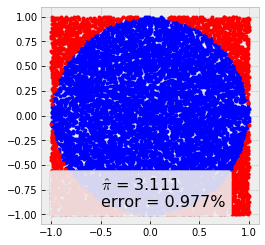

In [27]:
# 每次结果会不一样，样本越多必然也会越准确，可以尝试把N值改小改大
N = 10000

x, y = np.random.uniform(-1,1,size=(2,N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()* 4 / N
error = abs((pi - np.pi) / pi) * 100

outside = np.invert(inside)

plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0,0,label='$\hat \pi$ = {:4.3f}\nerror = {:4.3f}%'.format(pi, error), alpha=0)
plt.axis('square')
plt.legend(frameon=True, framealpha=0.9,fontsize=16)